# MLP
Training auf IDS18 80%  
Validierung auf IDS18 10%   
Test auf IDS18 10%  
Test auf IDS17 folgt in nächstem Skript

In [1]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

2024-11-22 17:37:48.468689: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-22 17:37:48.508257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 17:37:48.537617: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 17:37:48.545926: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 17:37:48.578444: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Maximale Zeilen und Spalten anzeigen
pd.set_option('display.max_rows', None)  # Zeilen
pd.set_option('display.max_columns', None)  # Spalten

# Logging Parameter
logging.basicConfig(
    #filename='31_cnn.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Verzeichnis der CSV-Dateien
ids18_prep_0 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_0'
ids17_prep_1 = '../01_Datensaetze/improved_cic-ids-2017/ids17_parquet_prep_1/ids17.parquet'
ids18_prep_1 = '../01_Datensaetze/improved_cse-cic-ids-2018/ids18_parquet_prep_1/ids18.parquet'
hybrid_train_prep_1 =  '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_train.parquet'
hybrid_test_prep_1 = '../01_Datensaetze/improved_hybrid_b17/hybrid_parquet_prep_1/hybrid_b17_test.parquet'

### Laden des Datensatzes

In [3]:
# Datensatz einlesen für Training 80%, Validierung 10% und Test 10%
df = pd.read_parquet(ids18_prep_0)
df['Label'] = df['Label'].cat.remove_unused_categories()
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.shape)
print(df.columns)

2024-11-22 17:37:51 - INFO - Class distribution
Label
BENIGN                          2967676
DoS Hulk                        1803160
DDoS-LOIC-HTTP                   289328
Botnet Ares                      142921
SSH-BruteForce                    94197
Infiltration - NMAP Portscan      89374
DoS GoldenEye                     22560
DoS Slowloris                      8490
Name: count, dtype: int64


(5417706, 82)
Index(['Dst Port', 'Protocol', 'Flow Duration', 'Total Fwd Packet',
       'Total Bwd packets', 'Total Length of Fwd Packet',
       'Total Length of Bwd Packet', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd RST Flags', 'Bwd RST Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Vari

### Testen mit nur 20 Features

In [4]:
selected_features = [
    'FWD Init Win Bytes',
    'Fwd Seg Size Min',
    'Bwd Packet Length Std',
    'Bwd Packet Length Max',
    'Packet Length Max',
    'Dst Port',
    'Bwd Init Win Bytes',
    'Fwd Packet Length Std',
    'Bwd Packet Length Mean',
    'Bwd Segment Size Avg',
    'Fwd IAT Min',
    'FIN Flag Count',
    'Fwd Packet Length Max',
    'Total Length of Bwd Packet',
    'Flow IAT Min',
    'Subflow Bwd Bytes',
    'Total Bwd packets',
    'Bwd PSH Flags',
    'Bwd IAT Total',
    'Average Packet Size',
]
df = df[selected_features + ['Label']]

In [5]:
X = df.iloc[:, :-1]  # Alle Spalten außer der letzten
print("Form von X:", X.shape)
y = df.iloc[:, -1]   # Die letzte Spalte
print("Form von y:", y.shape)


Form von X: (5417706, 20)
Form von y: (5417706,)


### Label Encoding für y

In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Einzigartige Labels:", label_encoder.classes_)
print("Kodierte Labels:", np.unique(y_encoded))

Einzigartige Labels: ['BENIGN' 'Botnet Ares' 'DDoS-LOIC-HTTP' 'DoS GoldenEye' 'DoS Hulk'
 'DoS Slowloris' 'Infiltration - NMAP Portscan' 'SSH-BruteForce']
Kodierte Labels: [0 1 2 3 4 5 6 7]


### Aufteilen der Daten in Trainings-, Validierungs- und Testdatensätze

In [7]:
# Aufteilen in Trainings- und temporäre Datensätze
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.20, random_state=42, stratify=y_encoded)

# Aufteilen in Validierungs- und Testdaten
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Form von X_train:", X_train.shape)
print("Form von X_val:", X_val.shape)
print("Form von X_test:", X_test.shape)


Form von X_train: (4334164, 20)
Form von X_val: (541771, 20)
Form von X_test: (541771, 20)


### Skallierung von X

In [8]:
# Skalieren der Daten
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit auf Trainingsdaten
X_val_scaled = scaler.transform(X_val)         # Transform auf Val.-Daten
X_test_scaled = scaler.transform(X_test)       # Transform auf Testdaten

### Überprüfen der Klassenverteilung

In [9]:
def print_class_distribution(y, dataset_name):
    unique, counts = np.unique(y, return_counts=True)
    total = len(y)
    print(f"Klassenverteilung in {dataset_name}:")
    for cls, count in zip(unique, counts):
        print(f"  Klasse {cls}: {count} Beispiele ({(count/total)*100:.2f}%)")
    print()

print_class_distribution(y_train, "Trainingsdatensatz")
print_class_distribution(y_val, "Validierungsdatensatz")
print_class_distribution(y_test, "Testdatensatz")

Klassenverteilung in Trainingsdatensatz:
  Klasse 0: 2374140 Beispiele (54.78%)
  Klasse 1: 114337 Beispiele (2.64%)
  Klasse 2: 231462 Beispiele (5.34%)
  Klasse 3: 18048 Beispiele (0.42%)
  Klasse 4: 1442528 Beispiele (33.28%)
  Klasse 5: 6792 Beispiele (0.16%)
  Klasse 6: 71499 Beispiele (1.65%)
  Klasse 7: 75358 Beispiele (1.74%)

Klassenverteilung in Validierungsdatensatz:
  Klasse 0: 296768 Beispiele (54.78%)
  Klasse 1: 14292 Beispiele (2.64%)
  Klasse 2: 28933 Beispiele (5.34%)
  Klasse 3: 2256 Beispiele (0.42%)
  Klasse 4: 180316 Beispiele (33.28%)
  Klasse 5: 849 Beispiele (0.16%)
  Klasse 6: 8937 Beispiele (1.65%)
  Klasse 7: 9420 Beispiele (1.74%)

Klassenverteilung in Testdatensatz:
  Klasse 0: 296768 Beispiele (54.78%)
  Klasse 1: 14292 Beispiele (2.64%)
  Klasse 2: 28933 Beispiele (5.34%)
  Klasse 3: 2256 Beispiele (0.42%)
  Klasse 4: 180316 Beispiele (33.28%)
  Klasse 5: 849 Beispiele (0.16%)
  Klasse 6: 8938 Beispiele (1.65%)
  Klasse 7: 9419 Beispiele (1.74%)



 ### Modell erstellen und trainieren

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
num_features = len(X_train.columns)  # Anzahl der Spalten in X_scaled
num_classes = len(label_encoder.classes_)  # Anzahl der Klassen

# # Definiere das Modell
model = Sequential([
    InputLayer(input_shape=(num_features,)),  # Eingabeschicht
    #Dense(64, activation='relu', kernel_regularizer=l2(0.001)),  # Erste versteckte Schicht mit l2
    Dense(32, input_dim=num_features, activation='relu'),  # Erste versteckte Schicht ohne l2
    # Dropout(0.3),  # Vermeidung von Overfitting
    # Dense(32, activation='relu'),  # Zweite versteckte Schicht
    Dense(num_classes, activation='softmax')  # Ausgabeschicht
])

# Definiere das Modell
# model = Sequential([
#     InputLayer(input_shape=(num_features,)),  # Eingabeschicht
#     Dense(32, activation='relu', kernel_regularizer=l2(0.001)),  # Erste versteckte Schicht mit l2
#     #Dense(64, input_dim=num_features, activation='relu'),  # Erste versteckte Schicht ohne l2
#     Dropout(0.3),  # Vermeidung von Overfitting
#     Dense(16, activation='relu'),  # Zweite versteckte Schicht
#     Dense(num_classes, activation='softmax')  # Ausgabeschicht
# ])

# Kompiliere das Modell
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Passend für Integer-kodierte Labels
              metrics=['sparse_categorical_accuracy'])  # Genauigkeit für integer Labels

# Modellübersicht
model.summary()



/home/michi/BA/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/home/michi/BA/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1732293475.033545 1213504 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732293475.150683 1213504 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1732293475.150721 1213504 cuda_executor.cc:1001] could not open file to

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 936 (3.66 KB)

 Trainable params: 936 (3.66 KB)

 Non-trainable params: 0 (0.00 B)

### Trainieren des Modells

In [11]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_scaled, y_val),
    callbacks=[early_stopping]
)

Epoch 1/20


I0000 00:00:1732293484.819705 1214182 service.cc:146] XLA service 0x7f8200008a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732293484.819778 1214182 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-11-22 17:38:04.835127: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-22 17:38:04.894271: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


   199/135443 ━━━━━━━━━━━━━━━━━━━━ 1:43 765us/step - loss: 1.4557 - sparse_categorical_accuracy: 0.5472      

I0000 00:00:1732293485.267008 1214182 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


135443/135443 ━━━━━━━━━━━━━━━━━━━━ 145s 1ms/step - loss: 0.0270 - sparse_categorical_accuracy: 0.9938 - val_loss: 0.0042 - val_sparse_categorical_accuracy: 0.9989
Epoch 2/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 151s 1ms/step - loss: 0.0042 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.0042 - val_sparse_categorical_accuracy: 0.9992
Epoch 3/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 143s 1ms/step - loss: 0.0034 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0026 - val_sparse_categorical_accuracy: 0.9993
Epoch 4/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 140s 1ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0024 - val_sparse_categorical_accuracy: 0.9993
Epoch 5/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 146s 1ms/step - loss: 0.0024 - sparse_categorical_accuracy: 0.9994 - val_loss: 0.0023 - val_sparse_categorical_accuracy: 0.9994
Epoch 6/20
135443/135443 ━━━━━━━━━━━━━━━━━━━━ 141s 1ms/step - loss: 0.0024 - sparse_categorical_accuracy: 0.9995 - val_loss: 0.0033 - val_spa

### Trainingsverlauf plotten

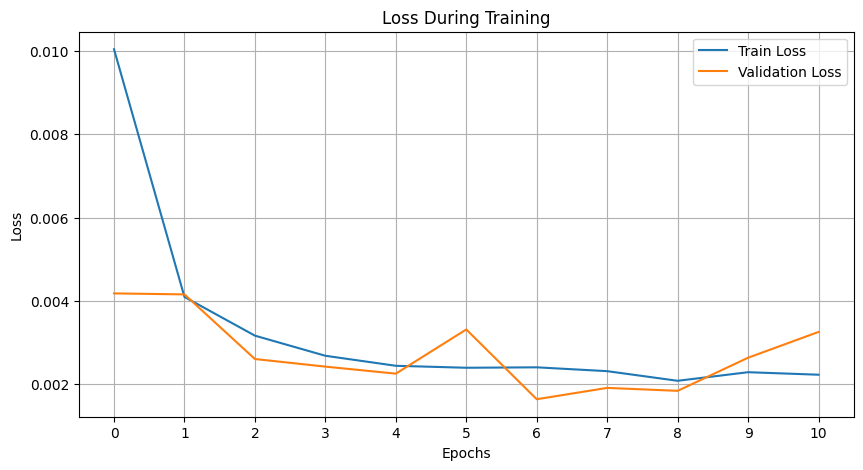

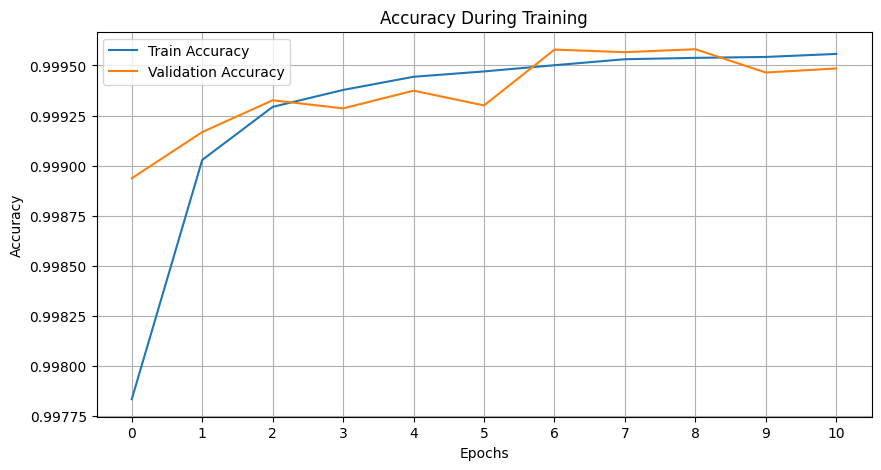

In [12]:
# Trainingsverlauf auslesen
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

# Verlust (Loss) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_loss)))
plt.show()

# Genauigkeit (Accuracy) plotten
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.xticks(range(len(train_accuracy)))
plt.show()

### Evaluierung des Modells auf dem Testdatensatz - Klassifikationsbericht und eine Konfusionsmatrix

In [13]:
# Vorhersagen auf dem Testdatensatz
y_pred_prob = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred_prob, axis=1)

# Klassifikationsbericht
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred_classes)

16931/16931 ━━━━━━━━━━━━━━━━━━━━ 11s 650us/step
                              precision    recall  f1-score   support

                      BENIGN       1.00      1.00      1.00    296768
                 Botnet Ares       1.00      1.00      1.00     14292
              DDoS-LOIC-HTTP       1.00      1.00      1.00     28933
               DoS GoldenEye       1.00      1.00      1.00      2256
                    DoS Hulk       1.00      1.00      1.00    180316
               DoS Slowloris       1.00      0.99      1.00       849
Infiltration - NMAP Portscan       0.99      0.98      0.99      8938
              SSH-BruteForce       1.00      1.00      1.00      9419

                    accuracy                           1.00    541771
                   macro avg       1.00      1.00      1.00    541771
                weighted avg       1.00      1.00      1.00    541771



Visualisierung der Konfusionsmatrix

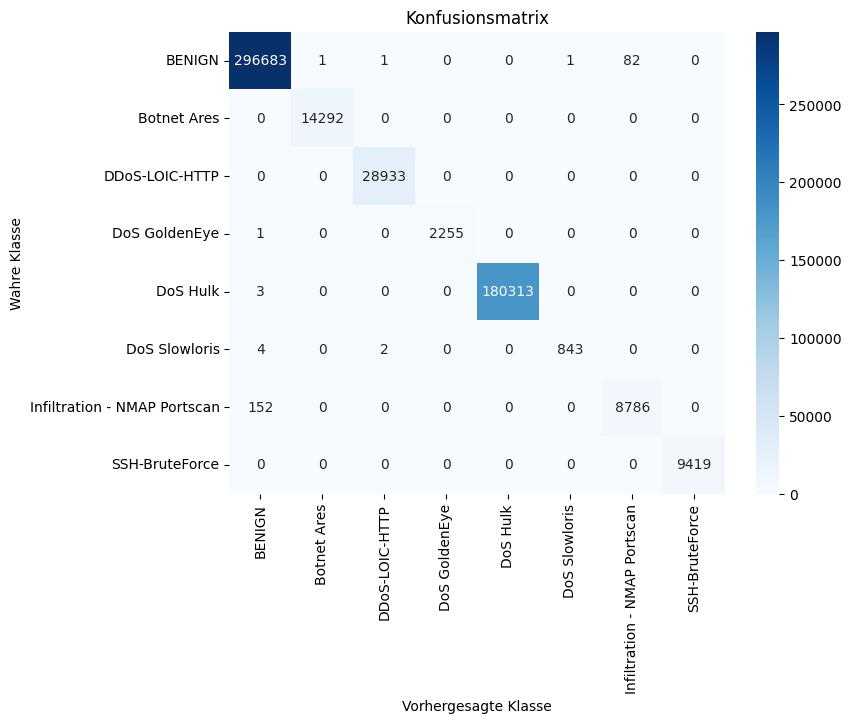

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wahre Klasse')
plt.title('Konfusionsmatrix')
plt.show()


### Speichern des Modells und der Vorverarbeitungsschritte

In [15]:
# Speichern des Modells
model.save('model.keras')

# Speichern des Label Encoders und Scalers
joblib.dump(label_encoder, 'label_encoder.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']